# Introduction

In this notebook, a comparative study has been performed on building **CNN** models on Brain Tumor dataset obtained from [kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri). The models have been prepared in 2 ways, one by training the entire neural network on the dataset and other by using Transfer learning.

<br>

---


### Fetching the data
Connecting the notebook to google drive containing the dataset

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [6]:
!unzip -q drive/MyDrive/Tumor\ detection/BrainTumorClassification.zip -d /content

Import the required libraries

In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import os, warnings
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

Set a seed for all random operations so that the code is reproducible always

In [8]:
def set_seed(seed=3141592):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

Set default matplotlib configuration

In [9]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
 # This will clean up all the output cells

Loading the training and testing datasets into a single tensorflow dataset.

This has been done because it was observed that the model obtained sufficient accuracy on training and validation datasets, but on the separate testing dataset, the required accuracy was not obtained, ultimately leading to the conclusion that there were features in the testing dataset not present in the traininig dataset. Upon mixing the datasets and removing the testing data after shuffling, gave sufficient accuracy. 

In [11]:
ds_set1_ = image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="training",
  labels='inferred',
  label_mode='categorical', # Setting the label_mode as 'categorical' avoids having to separately one-hot encode the dataset.
  image_size=[300,300],
  batch_size=32,
  shuffle=True,
  seed=123,
)

# Removing out 20% of the original Training dataset to keep aside as validation set.
ds_val_ = image_dataset_from_directory(
  './Training',
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  label_mode='categorical',
  image_size=[300,300],
  batch_size=32,
  shuffle=True,
  seed=123,
)

ds_set2_ = image_dataset_from_directory(
    './Testing',
    labels='inferred',
    label_mode='categorical',
    image_size=[300,300],
    batch_size=32,
    shuffle=True,
)

ds_train_ = ds_set1_.concatenate(ds_set2_)

# 10% of the final training dataset is kept aside for testing.
ds_test_ = ds_train_.take(9)
ds_train_ = ds_train_.skip(9)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.
<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


**Observing the dataset**

Class Names : 

In [ ]:
class_names = ds_val_.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Following are the 9 example images from the training dataset



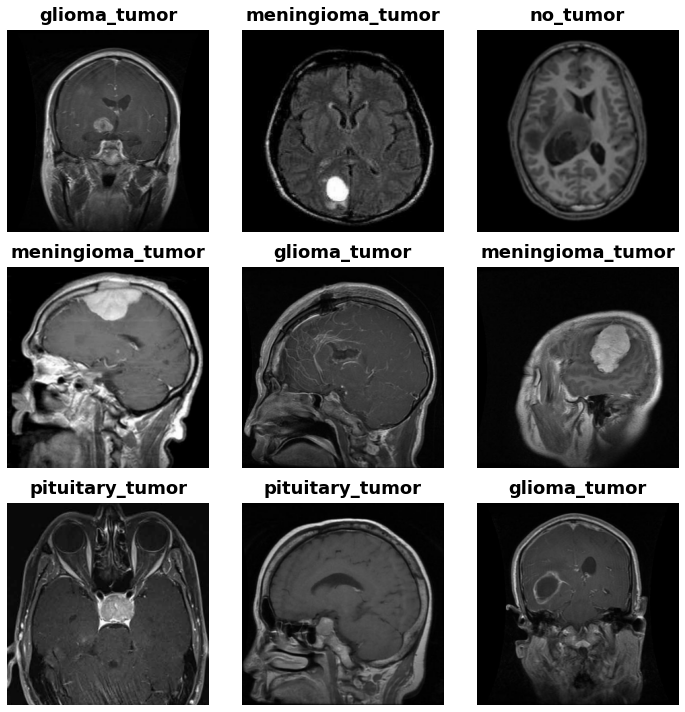

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in ds_train_.take(1):
  batch_result = np.argmax(labels, axis=1)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[batch_result[i]])
    plt.axis("off")

Let us look at the shape of the input and output of training dataset

In [ ]:
for image_batch, labels_batch in ds_train_:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32, 4)


Above we can see that the training dataset is divided into batches of 32, with image size in input of 300x300 with 3 channels corresponding to RGB

The labels_batch variable represents the output and shows that there are 32 labels corresponding to 32 input images from each batch.

Now, we will configure the dataset for performance by using cache and prefetch.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train_.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val_.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test_.cache().prefetch(buffer_size=AUTOTUNE)

##**Model trained with self-made base**

Let us now define the model below :

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

num_classes = len(class_names)

self_base_model = keras.Sequential([

    # Applying data augmentation so as to increase the training data size to 
    # improve generalization
    
    preprocessing.RandomRotation(factor=0.10, input_shape=((300, 300, 3))),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.experimental.preprocessing.Rescaling(1./255),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=5, filters=32, activation='relu', padding='same'),
    layers.MaxPool2D(),

    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=64, activation='relu', padding='same'),
    layers.MaxPool2D(),
    

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=128, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=256, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=512, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=512, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(kernel_size=3, filters=1024, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.Flatten(),

    layers.BatchNormalization(renorm=True),
    layers.Dense(256, activation='relu'),

    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),


    # The number of units in the output layer have to be the same as the number of classes because the output will be in the form of one-hot encoded vector.
    layers.BatchNormalization(renorm=True),
    layers.Dense(num_classes, activation='softmax'),
])




In [ ]:
self_base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 300, 300, 3)      0         
 tation)                                                         
                                                                 
 random_flip_1 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 batch_normalization_2 (Batc  (None, 300, 300, 3)      21        
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)     

Now we shall compile the model using the Adam optimizer

In [ ]:
self_base_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Adding EarlyStopping and ReduceLROnPlateau callbacks to prevent overfitting and adjusting the learning rate if the model is not learning respectively.

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,      # minimium amount of change to count as an improvement.
    patience=10,          # how many epochs to wait before stopping.
    restore_best_weights=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.3,         # factor by which to reduce the learning rate.
    patience = 2, 
    min_delta = 0.001,          
    mode='auto',
    verbose=1)

Fitting the model on the training data, while validating it on the previously separated validation data.

In [ ]:
history = self_base_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
76/76 [==============================] - 34s 342ms/step - loss: 5.0116 - accuracy: 0.3372 - val_loss: 18.4371 - val_accuracy: 0.3328 - lr: 0.0010
Epoch 2/100
76/76 [==============================] - 22s 292ms/step - loss: 8.3090 - accuracy: 0.3863 - val_loss: 1.6871 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 3/100
76/76 [==============================] - 22s 286ms/step - loss: 2.2629 - accuracy: 0.4013 - val_loss: 0.9653 - val_accuracy: 0.6672 - lr: 0.0010
Epoch 4/100
76/76 [==============================] - 22s 292ms/step - loss: 1.9802 - accuracy: 0.4650 - val_loss: 1.6721 - val_accuracy: 0.3223 - lr: 0.0010
Epoch 5/100
76/76 [==============================] - 22s 292ms/step - loss: 1.2052 - accuracy: 0.5254 - val_loss: 0.7619 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 6/100
76/76 [==============================] - 22s 292ms/step - loss: 1.5936 - accuracy: 0.5325 - val_loss: 1.0743 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 7/100
76/76 [==============================] - 22s 

Now that the learning is done, let us visualize how the model has learned with the help of certain plots.

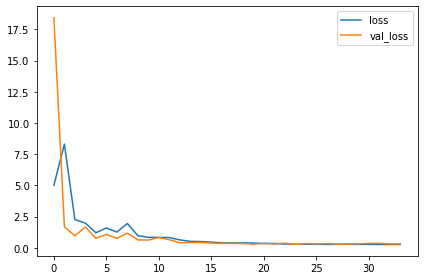

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()

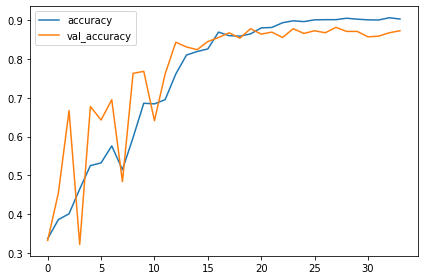

In [ ]:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

From the above plots, it can be seen that the model has not overfitted much and gives a reasonable accuracy of about 90%. The relevant data has been printed below.

In [ ]:
print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));

Minimum Validation Loss: 0.2782


In [ ]:
print("Maximum Validation Accuracy: {:0.4f}".format(history_frame['val_accuracy'].max()));

Maximum Validation Accuracy: 0.8815


Below, predictions are made on the testing data. The argmax function is used because the final output is obtained in the form of one-hot encoded vectors. The row indices here correspond to the labels of the 4 possible outcomes, and the row with the maximum value will be the predicted outcome.

In [ ]:
pred = self_base_model.predict(ds_test)
pred = np.argmax(pred,axis=1)
y_test = np.vstack([label for image, label in ds_test])
y_pred = np.argmax(y_test, axis=1)

Let us look at the classification report, which shows how well our data performed on the testing data.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        78
           1       0.93      0.78      0.85        82
           2       0.93      0.85      0.89        33
           3       0.84      0.99      0.91        95

    accuracy                           0.89       288
   macro avg       0.90      0.88      0.88       288
weighted avg       0.89      0.89      0.88       288



We run the evaluate command to get a solid number on accuracy that our model is able to achieve on the test data.

In [ ]:
self_base_model.evaluate(ds_test)

9/9 [==============================] - 1s 77ms/step - loss: 0.2987 - accuracy: 0.8854


[0.2987031936645508, 0.8854166865348816]

Let us now save the model in the SavedModel format provided by the tensorflow library.

In [ ]:
self_base_model.save("drive/MyDrive/Tumor detection/BrainTumorClassificationSelfBase")

INFO:tensorflow:Assets written to: drive/MyDrive/Tumor detection/BrainTumorClassificationSelfBase/assets


##**Model trained with Transfer Learning**

We shall use the EfficientNetB0 model which has been pretrained on ImageNet to help us in transfer learning. EfficientNetB0 is a baseline convolutional neural network architecture and has been trained such that it can learn quickly and has fewer parameters being more efficient and uniformly scaling in height, width and resolution using a compound coefficient. We turn off the include_top parameter as that will allow us to add our own head to the final model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

pretrained_base = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(300,300,3))

16719872/16705208 [==============================] - 0s 0us/step


The trainable attribute of the base is set to false to avoid further training the base

In [ ]:
pretrained_base.trainable = False

Now we set up the model. 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

num_classes = len(class_names)

pretrained_base_model = keras.Sequential([
                    preprocessing.RandomRotation(factor=0.10, input_shape=((300, 300, 3))),
                    preprocessing.RandomFlip(mode='horizontal'),
                    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),

                    pretrained_base,

                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.BatchNormalization(renorm=True),

                    layers.Dense(128, activation='relu'),
                    layers.BatchNormalization(renorm=True),
                    
                    layers.Dense(num_classes, activation='softmax'),
])

The summary of this model has been presented below

In [ ]:
pretrained_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 300, 300, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 300, 300, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 300, 300, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 10, 10, 1280)     4049571   
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 256)               32768256  
                                                        

Compiling the model

In [ ]:
pretrained_base_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Adding the same callbacks as the previous model.

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.3, 
    patience = 2, 
    min_delta = 0.001,          
    mode='auto',
    verbose=1)

Training the model, fewer epochs are used here as it is expected that the model will learn earlier due to transfer learning.

In [ ]:
history = pretrained_base_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=80,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/80
76/76 [==============================] - 41s 215ms/step - loss: 2.2715 - accuracy: 0.6582 - val_loss: 0.4756 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 2/80
76/76 [==============================] - 11s 142ms/step - loss: 0.7455 - accuracy: 0.7527 - val_loss: 0.6416 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/80
76/76 [==============================] - 11s 146ms/step - loss: 0.5153 - accuracy: 0.8135 - val_loss: 0.4035 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 4/80
76/76 [==============================] - 11s 147ms/step - loss: 0.4551 - accuracy: 0.8464 - val_loss: 0.3615 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 5/80
76/76 [==============================] - 11s 149ms/step - loss: 0.3876 - accuracy: 0.8747 - val_loss: 0.3716 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 6/80
76/76 [==============================] - 11s 148ms/step - loss: 0.3446 - accuracy: 0.8851 - val_loss: 0.2936 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 7/80
76/76 [==============================] - 11s 146ms/st

Visualization of the training. Here we can see that the model slightly overfitted, but the validation accuracy is still good enough.

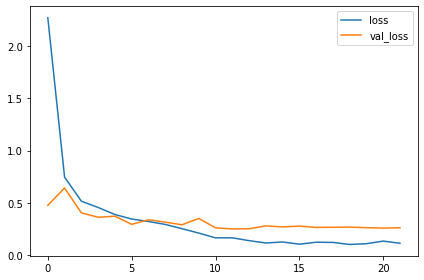

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()

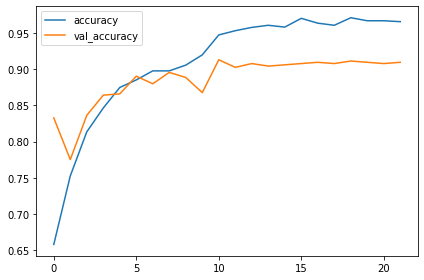

In [ ]:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

The predictions have been made on the test dataset and the classification report is generated. Desirable results have been achieved.

In [ ]:
pred = pretrained_base_model.predict(ds_test)
pred = np.argmax(pred,axis=1)
y_test = np.vstack([label for image, label in ds_test])
y_pred = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred,pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        78
           1       0.92      0.93      0.92        82
           2       1.00      0.94      0.97        33
           3       0.97      0.99      0.98        95

    accuracy                           0.95       288
   macro avg       0.96      0.95      0.95       288
weighted avg       0.95      0.95      0.95       288



Getting a definite number on the testing accuracy.

In [ ]:
pretrained_base_model.evaluate(ds_test, batch_size=32)

9/9 [==============================] - 1s 118ms/step - loss: 0.1548 - accuracy: 0.9514


[0.154801145195961, 0.9513888955116272]

Finally saving the model.

In [ ]:
pretrained_base_model.save('drive/MyDrive/Tumor detection/BrainTumorClassificationPretrainedBase')

INFO:tensorflow:Assets written to: drive/MyDrive/Tumor detection/BrainTumorClassificationPretrainedBase/assets
